## Exercise 5: Visualizing Predictions and Interpreting Confidence Metrics

After completing Exercise 1, you should have the following files in `01_basic/protein-dna-ion_pdb_7rce/`.

```
.
├── TERMS_OF_USE.md
├── protein-dna-ion_pdb_7rce_confidences.json
├── protein-dna-ion_pdb_7rce_data.json
├── protein-dna-ion_pdb_7rce_model.cif
├── protein-dna-ion_pdb_7rce_summary_confidences.json
├── ranking_scores.csv
├── seed-1_sample-0/
├── seed-1_sample-1/
├── seed-1_sample-2/
├── seed-1_sample-3/
└── seed-1_sample-4/
```

For convenience, the results for the highest ranking prediction are included in `data/protein-dna-ion_pdb_7rce/`:

In [1]:
import os
os.listdir("../data/protein-dna-ion_pdb_7rce")

['protein-dna-ion_pdb_7rce_confidences.json',
 'protein-dna-ion_pdb_7rce_model.cif',
 'TERMS_OF_USE.md',
 'protein-dna-ion_pdb_7rce_summary_confidences.json']

These result files should contain the <"name"> from the input json. The actual structure is contained in a macromolecular Crystallographic Information File (.mmCIF or .cif), a standard text file format used for representing crystallographic information. Since 2014, this is the default file format for the [Protein Data Bank](https://www.wwpdb.org/). The top-scoring model and confidence is in the root directory. Sub-directories contain the results for each sample and seed the rank of each is described in `ranking_scores.csv`.

### Visualizing the top-ranking predicted model structure

The mmcif file format is incredibly powerful. There is not enough time to go into the details of this format but know it is well supported by visualization applications such as Jmol, Chimera, and OpenRasMol and structure determination systems such as CCP4 and Phenix.

We will use a simple WebGL WebGL protein viewer widget to quickly render the structure

In [2]:
import nglview as nv
filepath = "../data/protein-dna-ion_pdb_7rce/protein-dna-ion_pdb_7rce_model.cif"
res_7rce = nv.show_file(filepath, ext='cif')
res_7rce

NGLWidget()

As a demonstration of structure analysis possible in python, we will download the cif file of the corresponding PDB crystallographic entry and superpose the experimentally derived model on the predicted model. First we will retreive the 7RCE model with biopython.

In [3]:
from Bio.PDB import PDBList

# Create an instance of the PDBList class
pdb_list = PDBList()

# Download the CIF file for PDB 7rce using retrieve_pdb_file
pdb_filename = pdb_list.retrieve_pdb_file("7rce", pdir="../data/PDB_files", file_format="mmCif")

# Print the name of the downloaded file
print(pdb_filename)


Structure exists: '../data/PDB_files/7rce.cif' 
../data/PDB_files/7rce.cif


Using the superpose approximation from NGviewer js library

In [50]:
import warnings
from Bio.PDB import MMCIFParser

# Suppress warnings in this cell
warnings.filterwarnings('ignore')

parser = MMCIFParser()
#parse mmcif files
pred_structure = parser.get_structure("prediction", "../data/protein-dna-ion_pdb_7rce/protein-dna-ion_pdb_7rce_model.cif")
expt_structure = parser.get_structure("experimental", "../data/PDB_files/7rce.cif")

#construct the superpose view
view = nv.NGLWidget()
expt = nv.BiopythonStructure(expt_structure)
pred = nv.BiopythonStructure(pred_structure)
view.add_structure(expt)
view.update_cartoon(color = "#b7b9bb", component=0)
view.add_structure(pred)
view.update_cartoon(color = "#79b1ce", component=1)
view._js("""
this.superpose(0, 1, true, ":A", ":A") 
""")
view

NGLWidget()

Other GUI options for protein structures include [pymol](https://biogrids.org/software/titles/pymol-open-source/) or [mol*](https://molstar.org/). The former is a commercial python package with a comprehensive software stack for creating molecule structures suitable for publications. The latter is a web-centric molecule viewer with integrations in the RCSB PDB, EMBL-EBI protein databases, and alphafold server. 

### Quality evaluation of Alphafold3 predicted structures using confidence scores

In order to hold practical significance, predicted protein structures must be accompanied by reliable measures of confidence. The output of AlphaFold3 returns confidence measures that can be used to identify regions of the predicted structure, and relative positions of different regions, that are more or less reliable. On a practial basis, the output of Alphafold3 contains the main metrics in the following files:

- `*_confidences.json`
    - the PAE and pLDDT
- `*_summary_confidences_.json`
    - the pTM and iPTM

#### PAE and pLDDT : Understanding predictive confidence 

These metrics broadly determine how the model trusts its atomic placement on a local(per atom/residue) and global(relative to domains) scale. These can help determine the plausibility of a structure by giving an estimate of how well the prediction will agree with an experimental structure. 


##### plDDT
pLDDT measures confidence in the local structure, estimating how well the prediction would agree with an experimental structure. It is based on the local distance difference test Cα (lDDT-Cα), which is a score that does not rely on superposition but assesses the correctness of the local distances (Mariani et al., 2013).

This per-atom confidence estimate is on a 0-100 scale where a higher value indicates higher confidence. pLDDT aims to predict a modified LDDT score that only considers distances to polymers. For proteins this is similar to the lDDT-Cα metric but with more granularity as it can vary per atom not just per residue. For ligand atoms, the modified LDDT considers the errors only between the ligand atom and polymers, not other ligand atoms. For DNA/RNA a wider radius of 30 Å is used for the modified LDDT instead of 15 Å.

The [mol* model viewer](https://molstar.org/) can color the 3D model by this scale allowing assessment of particular parts of the model.

![plddt scale](plddt_scale.png)

In [52]:
from pathlib import Path 
from ipymolstar import PDBeMolstar
model_path = Path('../data/protein-dna-ion_pdb_7rce/protein-dna-ion_pdb_7rce_model.cif')
custom_data = {
    'data': model_path.read_bytes(),
    'format': 'cif',
    'binary': False,
    }
view = PDBeMolstar(
    custom_data=custom_data,
    alphafold_view=True
)
view

PDBeMolstar(alphafold_view=True, bg_color='#F7F7F7', custom_data={'data': b'# By using this file you agree to …

Another visualization method is to plot the confidence score for each atom. Elevated, stable values indicate well-defined domains, while dips highlight regions that might be disordered or flexible.

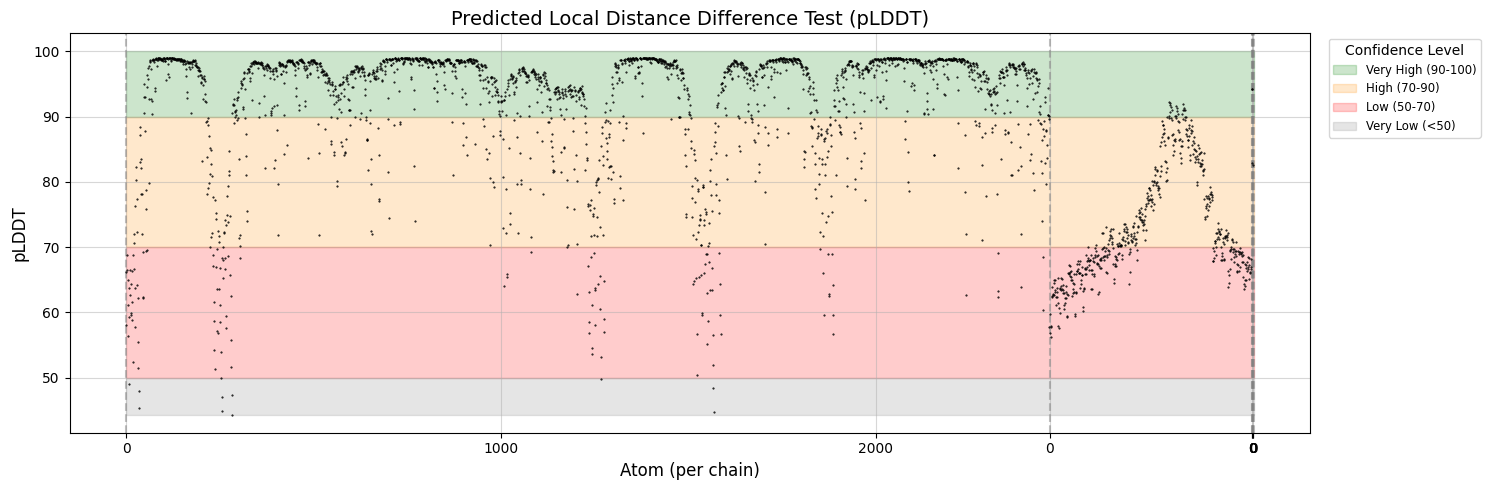

In [58]:
#import functions and libraries that will aid in parsing and visualizing
import json
from ccbfold import plot_plddt, plot_pae
#load the json file containing the pLDDT and PAE data
confidence_file = open('../data/protein-dna-ion_pdb_7rce/protein-dna-ion_pdb_7rce_confidences.json')
confidence_data = json.load(confidence_file)
#plot the pLDDT values
plot_plddt(confidence_data['atom_plddts'], confidence_data['atom_chain_ids'])

##### PAE
PAE is defined as the expected positional error at residue X, measured in Ångströms (Å), if the predicted and actual structures were aligned on residue Y. Therefore, PAE is effectively a measure of how confident the model is that the domains are well packed and that the relative placement of the domains in the predicted structure is correct. Lower PAE values between residues belonging to different domains indicate well-defined relative positions and orientations—suggesting stable domain-domain relationships. Conversely, higher PAE values for such residue pairs suggest uncertainty in how these domains are arranged relative to each other, indicating that their positions and orientations should not be taken as definitive.

We can plot a heat map to quickly assesses how confidently the model predicts the relative positions and orientations of residues across the protein. A dashed line (`show_chains=True`) draws the boundary between different protein chains, or different types of molecules/atoms (ie, RNA/DNA/ligand).

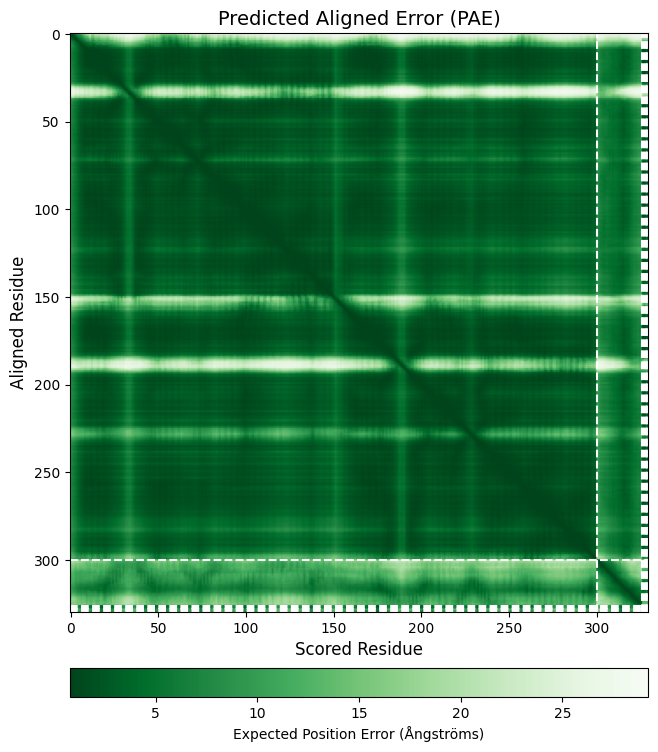

In [59]:
#plot the PAE values
plot_pae(confidence_data['pae'], confidence_data['token_chain_ids'], show_chains=True)